Dynamic Data (Unlimited Forecast) FIXED

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer, r2_score
import matplotlib.pyplot as plt
import joblib

# Define custom scorer for MAPE
def mape_scorer(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Make scorers from custom scoring functions
mape = make_scorer(mape_scorer, greater_is_better=False)

In [2]:
# Load the dataset
df_raw = pd.read_csv('../../Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)

# Extracting non-numeric columns
non_numeric_cols = ['is_holiday', 'weather_type', 'weather_description']

# Group by 'date_time' and aggregate: mean for numeric columns, mode for non-numeric columns
agg_funcs = {col: 'mean' for col in df_raw.columns if col not in non_numeric_cols}
agg_funcs.update({col: lambda x: x.mode()[0] if not x.mode().empty else np.nan for col in non_numeric_cols})

df_aggregated = df_raw.groupby('date_time').agg(agg_funcs)

In [3]:
df_aggregated

,date_time,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,traffic_volume,is_holiday,weather_type,weather_description
date_time,,,,,,,,,,,,,,,
2012-10-02 09:00:00,2012-10-02 09:00:00,121.000000,89.0,2.0,329.0,1.000000,1.000000,288.28,0.0,0.0,40.0,5545.0,None,Clouds,scattered clouds
2012-10-02 10:00:00,2012-10-02 10:00:00,178.000000,67.0,3.0,330.0,1.000000,1.000000,289.36,0.0,0.0,75.0,4516.0,None,Clouds,broken clouds
2012-10-02 11:00:00,2012-10-02 11:00:00,113.000000,66.0,3.0,329.0,2.000000,2.000000,289.58,0.0,0.0,90.0,4767.0,None,Clouds,overcast clouds
2012-10-02 12:00:00,2012-10-02 12:00:00,20.000000,66.0,3.0,329.0,5.000000,5.000000,290.13,0.0,0.0,90.0,5026.0,None,Clouds,overcast clouds
2012-10-02 13:00:00,2012-10-02 13:00:00,281.000000,65.0,3.0,329.0,7.000000,7.000000,291.14,0.0,0.0,75.0,4918.0,None,Clouds,broken clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-17 19:00:00,2017-05-17 19:00:00,112.333333,84.0,1.0,321.0,5.000000,5.000000,290.56,0.0,0.0,90.0,3136.0,None,Drizzle,light intensity drizzle
2017-05-17 20:00:00,2017-05-17 20:00:00,173.666667,86.0,1.0,326.0,4.000000,4.000000,288.89,0.0,0.0,90.0,2733.0,None,Mist,heavy intensity rain
2017-05-17 21:00:00,2017-05-17 21:00:00,122.666667,85.0,1.0,328.0,6.666667,6.666667,287.88,0.0,0.0,90.0,2348.0,None,Mist,light rain


In [4]:
# One-hot encode categorical features
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(df_aggregated[non_numeric_cols])

df_encode = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())

# Save the encoder using joblib
joblib.dump(encoder, 'encoder.joblib')

# Reset index of df_encode
df_encode.index = df_aggregated.index

# Concatenate with df_aggregated
df = pd.concat([df_aggregated, df_encode], axis=1)

# Add hour from the 'date_time' column
df['hour'] = df['date_time'].dt.hour

C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
df = df.drop(columns=non_numeric_cols)

In [6]:
# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Save 'date_time' for later use
date_time = df['date_time']

# Drop 'date_time' column before scaling
df = df.drop(columns=['date_time'])

In [7]:
df

,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,...,weather_description_thunderstorm with heavy rain,weather_description_thunderstorm with light drizzle,weather_description_thunderstorm with light rain,weather_description_very heavy rain,hour,traffic_volume_lag_1,traffic_volume_lag_2,traffic_volume_lag_3,traffic_volume_rolling_mean,traffic_volume_rolling_std
date_time,,,,,,,,,,,,,,,,,,,,,
2012-10-02 12:00:00,20.000000,66.0,3.0,329.0,5.000000,5.000000,290.13,0.0,0.0,90.0,...,0.0,0.0,0.0,0.0,12,4767.0,4516.0,5545.0,4942.666667,536.520581
2012-10-02 13:00:00,281.000000,65.0,3.0,329.0,7.000000,7.000000,291.14,0.0,0.0,75.0,...,0.0,0.0,0.0,0.0,13,5026.0,4767.0,4516.0,4769.666667,255.010457
2012-10-02 14:00:00,23.000000,65.0,3.0,328.0,6.000000,6.000000,291.72,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,14,4918.0,5026.0,4767.0,4903.666667,130.093556
2012-10-02 15:00:00,184.000000,64.0,3.0,328.0,7.000000,7.000000,293.17,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,15,5181.0,4918.0,5026.0,5041.666667,132.198084
2012-10-02 16:00:00,167.000000,64.0,3.0,327.0,7.000000,7.000000,293.86,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,16,5584.0,5181.0,4918.0,5227.666667,335.443488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-17 19:00:00,112.333333,84.0,1.0,321.0,5.000000,5.000000,290.56,0.0,0.0,90.0,...,0.0,0.0,0.0,0.0,19,4864.0,5763.0,6426.0,5684.333333,783.965773
2017-05-17 20:00:00,173.666667,86.0,1.0,326.0,4.000000,4.000000,288.89,0.0,0.0,90.0,...,0.0,0.0,0.0,0.0,20,3136.0,4864.0,5763.0,4587.666667,1335.122591
2017-05-17 21:00:00,122.666667,85.0,1.0,328.0,6.666667,6.666667,287.88,0.0,0.0,90.0,...,0.0,0.0,0.0,0.0,21,2733.0,3136.0,4864.0,3577.666667,1132.074350


In [8]:
# Scale the numerical features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Convert scaled data back to DataFrame and add 'date_time' column back
df_scaled = pd.DataFrame(df_scaled, columns=[col for col in df.columns if col != 'date_time'])
df_scaled['date_time'] = date_time.values

# Split the data into train and test sets
total_samples = df_scaled.shape[0]
split_index = int(total_samples * 0.9)

X_train = df_scaled.iloc[:split_index].drop(columns=['date_time'])
y_train = y.iloc[:split_index]
X_test = df_scaled.iloc[split_index:].drop(columns=['date_time'])
y_test = y.iloc[split_index:]

X_train = X_train.drop(target, axis=1)
X_test = X_test.drop(target, axis=1)

In [9]:

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100],
    'max_depth': [7],
    'learning_rate': [0.1],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'gamma': [1],
    'reg_alpha': [1]
}

# Update the scoring parameter with a dictionary of metrics
scoring = {
    'RMSE': 'neg_root_mean_squared_error',
    'MSE': 'neg_mean_squared_error',
    'MAE': 'neg_mean_absolute_error',
    'MAPE': mape
}

# Create a TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Initialize the GridSearchCV object with the time series cross-validator
grid_search = GridSearchCV(
    estimator=xgboost_model,
    param_grid=param_grid,
    scoring=scoring,
    refit='RMSE',
    cv=tscv,
    verbose=1
)

# Fit the grid search to the scaled data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_parameters_grid = grid_search.best_params_
print(f"Best parameters found with GridSearchCV: {best_parameters_grid}")

# Train the best model on the scaled data
best_model_grid = grid_search.best_estimator_

# Save the best model
joblib.dump(best_model_grid, 'best_xgboost_model_gridsearch.joblib')


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found with GridSearchCV: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 1, 'subsample': 1.0}


['best_xgboost_model_gridsearch.joblib']

In [10]:
y_train_pred_grid = best_model_grid.predict(X_train)
train_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_grid)),
    'MSE': mean_squared_error(y_train, y_train_pred_grid),
    'MAE': mean_absolute_error(y_train, y_train_pred_grid),
    'MAPE': mape_scorer(y_train, y_train_pred_grid),
    'R2': r2_score(y_train, y_train_pred_grid)
}

# Evaluate metrics on the validation set
y_val_pred_grid = best_model_grid.predict(X_test)
val_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_val_pred_grid)),
    'MSE': mean_squared_error(y_test, y_val_pred_grid),
    'MAE': mean_absolute_error(y_test, y_val_pred_grid),
    'MAPE': mape_scorer(y_test, y_val_pred_grid),
    'R2': r2_score(y_test, y_val_pred_grid)
}

# Print and compare metrics for GridSearchCV
print("\nMetrics with GridSearchCV:")
print("Training Set Metrics:")
print(train_metrics_grid)
print("\nValidation Set Metrics:")
print(val_metrics_grid)


Metrics with GridSearchCV:
Training Set Metrics:
{'RMSE': 264.9754555382364, 'MSE': 70211.9920376959, 'MAE': 171.057436243803, 'MAPE': 17.345166425062075, 'R2': 0.982171937921688}

Validation Set Metrics:
{'RMSE': 300.76121820600434, 'MSE': 90457.31037675976, 'MAE': 192.4876635492411, 'MAPE': 8.715157028652786, 'R2': 0.9779178938811035}


In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(25727, 68) (25727,)
(2859, 68) (2859,)


In [12]:
df.columns

Index(['air_pollution_index', 'humidity', 'wind_speed', 'wind_direction',
       'visibility_in_miles', 'dew_point', 'temperature', 'rain_p_h',
       'snow_p_h', 'clouds_all', 'traffic_volume', 'is_holiday_Christmas Day',
       'is_holiday_Columbus Day', 'is_holiday_Independence Day',
       'is_holiday_Labor Day', 'is_holiday_Martin Luther King Jr Day',
       'is_holiday_Memorial Day', 'is_holiday_New Years Day',
       'is_holiday_None', 'is_holiday_State Fair',
       'is_holiday_Thanksgiving Day', 'is_holiday_Veterans Day',
       'is_holiday_Washingtons Birthday', 'weather_type_Clear',
       'weather_type_Clouds', 'weather_type_Drizzle', 'weather_type_Fog',
       'weather_type_Haze', 'weather_type_Mist', 'weather_type_Rain',
       'weather_type_Snow', 'weather_type_Squall', 'weather_type_Thunderstorm',
       'weather_description_SQUALLS', 'weather_description_Sky is Clear',
       'weather_description_broken clouds', 'weather_description_drizzle',
       'weather_descriptio

In [13]:
df

,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,...,weather_description_thunderstorm with heavy rain,weather_description_thunderstorm with light drizzle,weather_description_thunderstorm with light rain,weather_description_very heavy rain,hour,traffic_volume_lag_1,traffic_volume_lag_2,traffic_volume_lag_3,traffic_volume_rolling_mean,traffic_volume_rolling_std
date_time,,,,,,,,,,,,,,,,,,,,,
2012-10-02 12:00:00,20.000000,66.0,3.0,329.0,5.000000,5.000000,290.13,0.0,0.0,90.0,...,0.0,0.0,0.0,0.0,12,4767.0,4516.0,5545.0,4942.666667,536.520581
2012-10-02 13:00:00,281.000000,65.0,3.0,329.0,7.000000,7.000000,291.14,0.0,0.0,75.0,...,0.0,0.0,0.0,0.0,13,5026.0,4767.0,4516.0,4769.666667,255.010457
2012-10-02 14:00:00,23.000000,65.0,3.0,328.0,6.000000,6.000000,291.72,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,14,4918.0,5026.0,4767.0,4903.666667,130.093556
2012-10-02 15:00:00,184.000000,64.0,3.0,328.0,7.000000,7.000000,293.17,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,15,5181.0,4918.0,5026.0,5041.666667,132.198084
2012-10-02 16:00:00,167.000000,64.0,3.0,327.0,7.000000,7.000000,293.86,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,16,5584.0,5181.0,4918.0,5227.666667,335.443488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-17 19:00:00,112.333333,84.0,1.0,321.0,5.000000,5.000000,290.56,0.0,0.0,90.0,...,0.0,0.0,0.0,0.0,19,4864.0,5763.0,6426.0,5684.333333,783.965773
2017-05-17 20:00:00,173.666667,86.0,1.0,326.0,4.000000,4.000000,288.89,0.0,0.0,90.0,...,0.0,0.0,0.0,0.0,20,3136.0,4864.0,5763.0,4587.666667,1335.122591
2017-05-17 21:00:00,122.666667,85.0,1.0,328.0,6.666667,6.666667,287.88,0.0,0.0,90.0,...,0.0,0.0,0.0,0.0,21,2733.0,3136.0,4864.0,3577.666667,1132.074350


In [14]:
date_time

date_time
2012-10-02 12:00:00   2012-10-02 12:00:00
2012-10-02 13:00:00   2012-10-02 13:00:00
2012-10-02 14:00:00   2012-10-02 14:00:00
2012-10-02 15:00:00   2012-10-02 15:00:00
2012-10-02 16:00:00   2012-10-02 16:00:00
                              ...        
2017-05-17 19:00:00   2017-05-17 19:00:00
2017-05-17 20:00:00   2017-05-17 20:00:00
2017-05-17 21:00:00   2017-05-17 21:00:00
2017-05-17 22:00:00   2017-05-17 22:00:00
2017-05-17 23:00:00   2017-05-17 23:00:00
Name: date_time, Length: 28586, dtype: datetime64[ns]

In [15]:
df = pd.concat([date_time, df], axis=1)

In [1]:
df.columns

NameError: name 'df' is not defined

In [17]:
# Function to update the lagged features with the new prediction
def update_lagged_features(df, new_prediction, max_lags=3):
    for i in range(max_lags-1, 0, -1):
        df[f'traffic_volume_lag_{i+1}'] = df[f'traffic_volume_lag_{i}']
    df['traffic_volume_lag_1'] = new_prediction

# Initialize DataFrame for dynamic forecasting
df_dynamic_forecast = X_test.copy()
df_dynamic_forecast['forecasted_traffic_volume'] = np.nan

# Number of steps to forecast
forecast_steps = 720

for i in range(forecast_steps):
    # Predict the traffic volume for the next time step
    current_prediction = best_model_grid.predict(df_dynamic_forecast.iloc[i:i+1].drop(columns=['forecasted_traffic_volume']))[0]
    df_dynamic_forecast.at[df_dynamic_forecast.index[i], 'forecasted_traffic_volume'] = current_prediction

    # Update lagged features with the new prediction for the next iteration
    if i + 1 < forecast_steps:
        update_lagged_features(df_dynamic_forecast.iloc[i + 1], current_prediction)

C:\Users\Nadim Pramono\AppData\Local\Temp\ipykernel_3112\2961905572.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'traffic_volume_lag_{i+1}'] = df[f'traffic_volume_lag_{i}']
C:\Users\Nadim Pramono\AppData\Local\Temp\ipykernel_3112\2961905572.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['traffic_volume_lag_1'] = new_prediction
C:\Users\Nadim Pramono\AppData\Local\Temp\ipykernel_3112\2961905572.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [18]:
# Initialize the DataFrame
test_date_times = df['date_time'][split_index:].reset_index(drop=True)

df_result = pd.DataFrame({
    'date_time': test_date_times,
    'actual_traffic_volume': y_test.reset_index(drop=True),
    'lag_1': np.nan,
    'lag_2': np.nan,
    'lag_3': np.nan,
    'forecasted_traffic_volume': df_dynamic_forecast['forecasted_traffic_volume'].reset_index(drop=True)
})

# Set the initial lagged values from the historical data
df_result.loc[0, 'lag_1'] = df.loc[df.index[split_index - 1], 'traffic_volume']
df_result.loc[0, 'lag_2'] = df.loc[df.index[split_index - 2], 'traffic_volume']
df_result.loc[0, 'lag_3'] = df.loc[df.index[split_index - 3], 'traffic_volume']


# Update the lagged values with the forecasted values in each step
for i in range(1, len(df_result)):
    df_result.loc[i, 'lag_1'] = df_result.loc[i - 1, 'forecasted_traffic_volume']
    df_result.loc[i, 'lag_2'] = df_result.loc[i - 1, 'lag_1']
    df_result.loc[i, 'lag_3'] = df_result.loc[i - 1, 'lag_2']

# Display the DataFrame
print(df_result.head(forecast_steps))


              date_time  actual_traffic_volume        lag_1        lag_2  \
0   2017-01-17 17:00:00                 5840.0  6184.000000  5675.000000   
1   2017-01-17 18:00:00                 4278.0  5812.288574  6184.000000   
2   2017-01-17 19:00:00                 2982.0  4339.695801  5812.288574   
3   2017-01-17 20:00:00                 2491.0  3005.448486  4339.695801   
4   2017-01-17 21:00:00                 3331.0  2556.062500  3005.448486   
..                  ...                    ...          ...          ...   
715 2017-02-16 21:00:00                 3283.0  2938.450928  3402.315186   
716 2017-02-16 22:00:00                 3751.0  2803.368896  2938.450928   
717 2017-02-16 23:00:00                 1319.0  2920.713135  2803.368896   
718 2017-02-17 00:00:00                  692.0  1775.091309  2920.713135   
719 2017-02-17 01:00:00                  402.0   759.608459  1775.091309   

           lag_3  forecasted_traffic_volume  
0    5016.000000                5812.2885

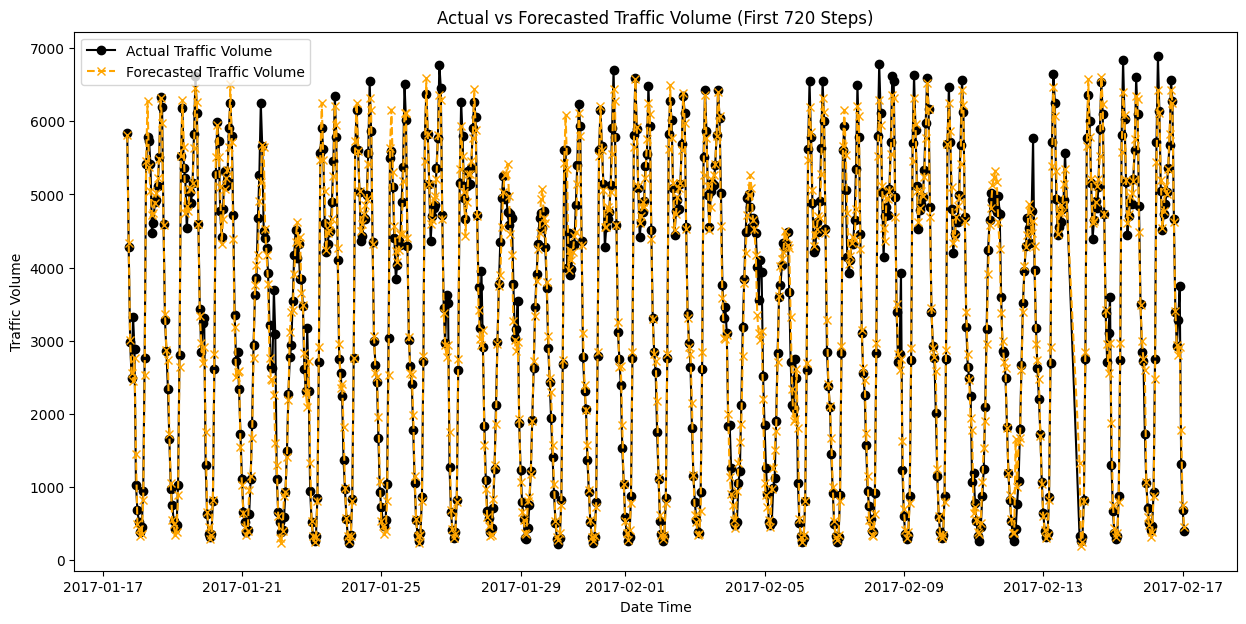

In [19]:
import matplotlib.pyplot as plt

# Select the steps for plotting
df_plot = df_result.head(forecast_steps)

# Plotting the actual vs. forecasted traffic volumes
plt.figure(figsize=(15, 7))
plt.plot(df_plot['date_time'], df_plot['actual_traffic_volume'], label='Actual Traffic Volume', color='black', marker='o')
plt.plot(df_plot['date_time'], df_plot['forecasted_traffic_volume'], label='Forecasted Traffic Volume', color='orange', linestyle='--', marker='x')

# Adding labels and title
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.title('Actual vs Forecasted Traffic Volume (First 720 Steps)')
plt.legend()

# Display the plot
plt.show()

In [20]:
df_result.tail()

,date_time,actual_traffic_volume,lag_1,lag_2,lag_3,forecasted_traffic_volume
2854,2017-05-17 19:00:00,3136.0,NaN,NaN,NaN,NaN
2855,2017-05-17 20:00:00,2733.0,NaN,NaN,NaN,NaN
2856,2017-05-17 21:00:00,2348.0,NaN,NaN,NaN,NaN
2857,2017-05-17 22:00:00,2194.0,NaN,NaN,NaN,NaN
2858,2017-05-17 23:00:00,1328.0,NaN,NaN,NaN,NaN


In [21]:
df_result.dropna(inplace=True)

In [22]:
actual_values = df_result['actual_traffic_volume']
new_forecasted_values = df_result['forecasted_traffic_volume']

# Evaluate metrics on the training set
y_train_pred_grid = best_model_grid.predict(X_train)
train_metrics_grid = {
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_grid)),
    'MSE': mean_squared_error(y_train, y_train_pred_grid),
    'MAE': mean_absolute_error(y_train, y_train_pred_grid),
    'MAPE': mape_scorer(y_train, y_train_pred_grid),
    'R2': r2_score(y_train, y_train_pred_grid)  # R2 score for training set
}

# Calculate the metrics for forecasted values
forecast_metrics = {
    'RMSE': np.sqrt(mean_squared_error(actual_values, new_forecasted_values)),
    'MSE': mean_squared_error(actual_values, new_forecasted_values),
    'MAE': mean_absolute_error(actual_values, new_forecasted_values),
    'MAPE': mape_scorer(actual_values, new_forecasted_values),
    'R2': r2_score(actual_values, new_forecasted_values)  # R2 score for forecast
}

# Print the metrics
print("\nMetrics for Train Values:")
print(train_metrics_grid)
print("\nMetrics for Forecasted Values:")
print(forecast_metrics)



Metrics for Train Values:
{'RMSE': 264.9754555382364, 'MSE': 70211.9920376959, 'MAE': 171.057436243803, 'MAPE': 17.345166425062075, 'R2': 0.982171937921688}

Metrics for Forecasted Values:
{'RMSE': 278.9909617693181, 'MSE': 77835.95674896913, 'MAE': 186.5811789194743, 'MAPE': 8.982109016729668, 'R2': 0.9806616981393182}


[22:06:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


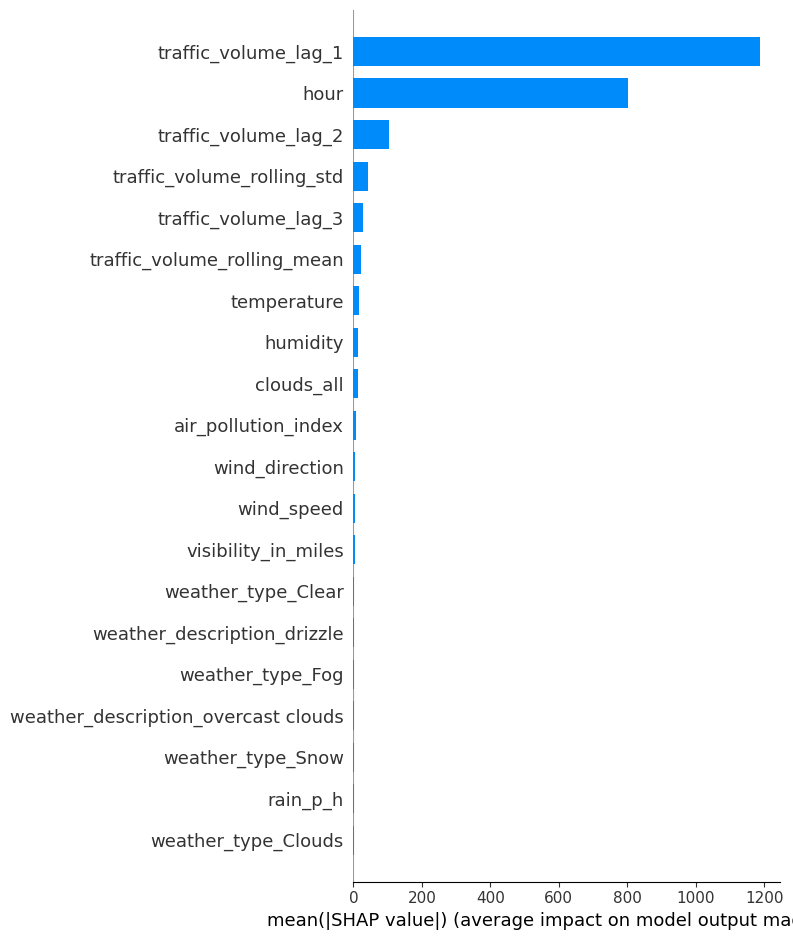

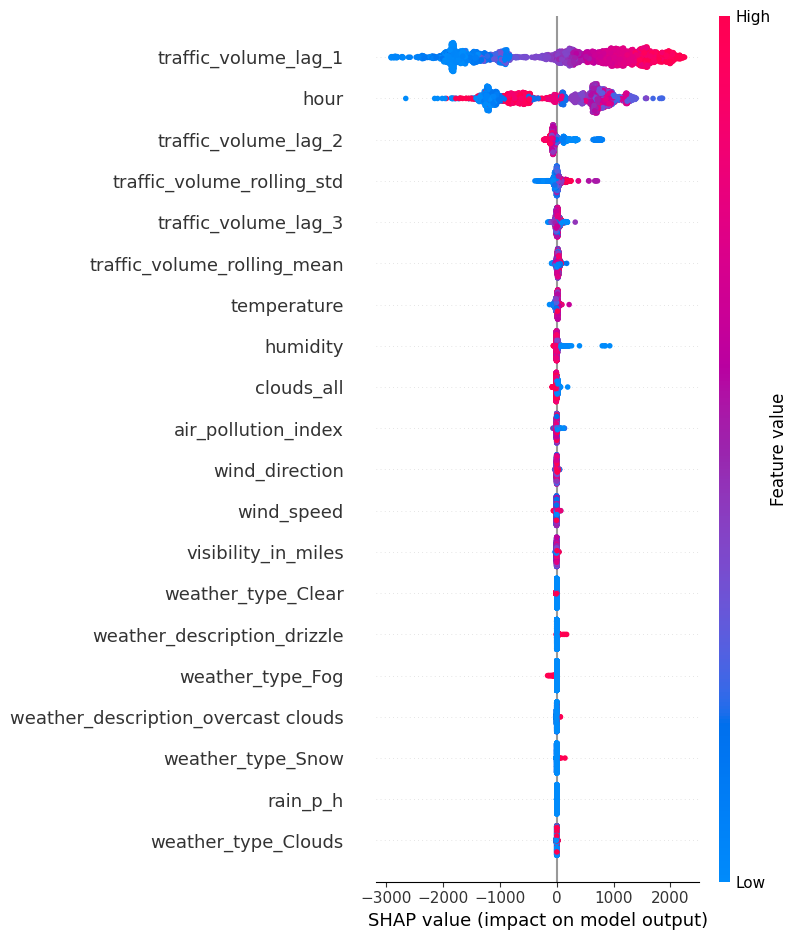

ValueError: Could not find feature named: traffic_volume

In [23]:
import shap

# Create a SHAP Tree Explainer for the XGBoost model
explainer = shap.TreeExplainer(best_model_grid)

# Calculate SHAP values - this might take some time for larger datasets
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Force plot for a single prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

# Mean absolute SHAP values
shap.summary_plot(shap_values, X_test)

# Dependence plot for a specific feature
shap.dependence_plot("traffic_volume", shap_values, X_test)


In [28]:
# Check categories in encoder
joblib.dump(scaler, 'scaler2.joblib')

['scaler2.joblib']

In [26]:
print(df_encode['weather_type'].unique())
print(df_encode['weather_description'].unique())

KeyError: 'weather_type'